# Getting to know your data with Pandas

## Pandas

Pandas is the Python Data Analysis Library. 

Pandas is an extremely versatile tool for manipulating datasets.   

It also produces high quality plots with matplotlib, and integrates nicely with other libraries that expect NumPy arrays.

The most important tool provided by Pandas is the **data frame.**

A data frame is a table in which each row and column is given a label.

Pandas DataFrames are documented at:

http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.html

## Getting started

In [201]:
import pandas as pd
import pandas_datareader.data as web
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from datetime import datetime

#pd.__version__

%matplotlib inline

## Fetching, storing and retrieving your data

For demonstration purposes, we'll use a library built-in to Pandas that fetches data from standard online sources, such as Yahoo! Finance.

More information on what types of data you can fetch is at:
http://pandas.pydata.org/pandas-docs/stable/remote_data.html

In [202]:
stocks = 'YELP'
data_source = 'yahoo'
start = datetime(2015,1,1)
end = datetime(2015,12,31)

yahoo_stocks = web.DataReader(stocks, data_source, start, end)

yahoo_stocks.head()
yahoo_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2015-01-02 to 2015-12-31
Data columns (total 6 columns):
Open         252 non-null float64
High         252 non-null float64
Low          252 non-null float64
Close        252 non-null float64
Adj Close    252 non-null float64
Volume       252 non-null int64
dtypes: float64(5), int64(1)
memory usage: 13.8 KB


### Reading data from a .csv file

In [203]:
yahoo_stocks.to_csv('yahoo_data.csv')
print(open('yahoo_data.csv').read())

Date,Open,High,Low,Close,Adj Close,Volume
2015-01-02,55.459998999999996,55.599998,54.240002000000004,55.150002,55.150002,1664500
2015-01-05,54.540001000000004,54.950001,52.330002,52.529999,52.529999,2023000
2015-01-06,52.549999,53.93,50.75,52.439999,52.439999,3762800
2015-01-07,53.32,53.75,51.759997999999996,52.209998999999996,52.209998999999996,1548200
2015-01-08,52.59,54.139998999999996,51.759997999999996,53.830002,53.830002,2015300
2015-01-09,55.959998999999996,56.990002000000004,54.720001,56.07,56.07,6222600
2015-01-12,56.0,56.060001,53.43,54.02,54.02,2405100
2015-01-13,54.470001,54.799999,52.52,53.18,53.18,1952100
2015-01-14,52.799999,53.68,51.459998999999996,52.200001,52.200001,1854600
2015-01-15,53.0,53.610001000000004,50.029999,50.119999,50.119999,2647800
2015-01-16,50.18,51.490002000000004,50.029999,51.389998999999996,51.389998999999996,2183300
2015-01-20,51.650002,51.779999,50.689999,51.41,51.41,1227600
2015-01-21,51.200001,53.5,51.200001,53.41,53.41,3248100
2015-01-22,53.869

In [204]:
df = pd.read_csv('yahoo_data.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,55.459999,55.599998,54.240002,55.150002,55.150002,1664500
1,2015-01-05,54.540001,54.950001,52.330002,52.529999,52.529999,2023000
2,2015-01-06,52.549999,53.930000,50.750000,52.439999,52.439999,3762800
3,2015-01-07,53.320000,53.750000,51.759998,52.209999,52.209999,1548200
4,2015-01-08,52.590000,54.139999,51.759998,53.830002,53.830002,2015300
5,2015-01-09,55.959999,56.990002,54.720001,56.070000,56.070000,6222600
6,2015-01-12,56.000000,56.060001,53.430000,54.020000,54.020000,2405100
7,2015-01-13,54.470001,54.799999,52.520000,53.180000,53.180000,1952100
8,2015-01-14,52.799999,53.680000,51.459999,52.200001,52.200001,1854600
9,2015-01-15,53.000000,53.610001,50.029999,50.119999,50.119999,2647800


The number of rows in the DataFrame:

In [205]:
len(df)

252

## Working with data columns

The columns or "features" in your data

In [206]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

Selecting a single column from your data

In [207]:
df['Open']

0      55.459999
1      54.540001
2      52.549999
3      53.320000
4      52.590000
5      55.959999
6      56.000000
7      54.470001
8      52.799999
9      53.000000
10     50.180000
11     51.650002
12     51.200001
13     53.869999
14     54.660000
15     55.119999
16     56.060001
17     56.150002
18     52.849998
19     52.590000
20     52.939999
21     53.830002
22     55.529999
23     57.599998
24     47.700001
25     44.910000
26     43.830002
27     45.389999
28     46.450001
29     48.509998
         ...    
222    27.540001
223    28.190001
224    28.100000
225    30.580000
226    29.459999
227    29.790001
228    30.500000
229    30.110001
230    30.110001
231    30.299999
232    31.389999
233    30.530001
234    30.379999
235    29.809999
236    30.980000
237    30.110001
238    30.690001
239    29.600000
240    29.680000
241    26.889999
242    28.139999
243    27.309999
244    27.170000
245    26.250000
246    27.950001
247    28.270000
248    28.120001
249    27.9500

Another way of selecting a single column from your data

In [208]:
df.Open

0      55.459999
1      54.540001
2      52.549999
3      53.320000
4      52.590000
5      55.959999
6      56.000000
7      54.470001
8      52.799999
9      53.000000
10     50.180000
11     51.650002
12     51.200001
13     53.869999
14     54.660000
15     55.119999
16     56.060001
17     56.150002
18     52.849998
19     52.590000
20     52.939999
21     53.830002
22     55.529999
23     57.599998
24     47.700001
25     44.910000
26     43.830002
27     45.389999
28     46.450001
29     48.509998
         ...    
222    27.540001
223    28.190001
224    28.100000
225    30.580000
226    29.459999
227    29.790001
228    30.500000
229    30.110001
230    30.110001
231    30.299999
232    31.389999
233    30.530001
234    30.379999
235    29.809999
236    30.980000
237    30.110001
238    30.690001
239    29.600000
240    29.680000
241    26.889999
242    28.139999
243    27.309999
244    27.170000
245    26.250000
246    27.950001
247    28.270000
248    28.120001
249    27.9500

In [209]:
df[['Open','Close']].head()

,Open,Close
0,55.459999,55.150002
1,54.540001,52.529999
2,52.549999,52.439999
3,53.320000,52.209999
4,52.590000,53.830002


In [210]:
df.Date.head(10)

0    2015-01-02
1    2015-01-05
2    2015-01-06
3    2015-01-07
4    2015-01-08
5    2015-01-09
6    2015-01-12
7    2015-01-13
8    2015-01-14
9    2015-01-15
Name: Date, dtype: object

In [211]:
df.Date.tail(10)

242    2015-12-17
243    2015-12-18
244    2015-12-21
245    2015-12-22
246    2015-12-23
247    2015-12-24
248    2015-12-28
249    2015-12-29
250    2015-12-30
251    2015-12-31
Name: Date, dtype: object

Changing the column names:

In [212]:
new_column_names = [x.lower().replace(' ','_') for x in df.columns]
df.columns = new_column_names
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
date         252 non-null object
open         252 non-null float64
high         252 non-null float64
low          252 non-null float64
close        252 non-null float64
adj_close    252 non-null float64
volume       252 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


Now **all** columns can be accessed using the **dot** notation:

In [213]:
df.adj_close.head()

0    55.150002
1    52.529999
2    52.439999
3    52.209999
4    53.830002
Name: adj_close, dtype: float64

## Data Frame methods

A DataFrame object has many useful methods.

In [214]:
df.mean()

open         3.728766e+01
high         3.805464e+01
low          3.656373e+01
close        3.729917e+01
adj_close    3.729917e+01
volume       3.491051e+06
dtype: float64

In [215]:
df.std()

open         1.128093e+01
high         1.138111e+01
low          1.113097e+01
close        1.125233e+01
adj_close    1.125233e+01
volume       4.145546e+06
dtype: float64

In [216]:
df.median()

open         3.796500e+01
high         3.871500e+01
low          3.637500e+01
close        3.783500e+01
adj_close    3.783500e+01
volume       2.354050e+06
dtype: float64

In [217]:
df.open.mean()

37.28765869841269

In [218]:
df.high.mean()

38.05464295238094

### Plotting methods

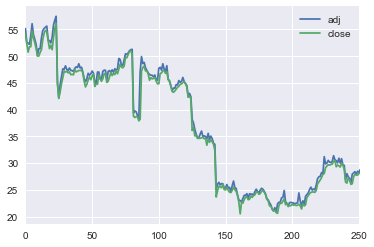

In [219]:
df.adj_close.plot(label='adj')
df.low.plot(label='close')
plt.legend(loc='best')

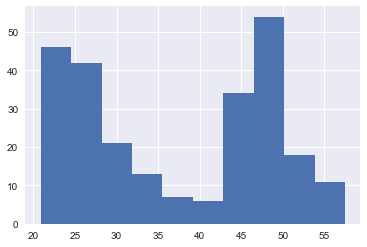

In [220]:
df.adj_close.hist()

### Bulk Operations

Methods like **sum( )** and **std( )** work on entire columns. 

We can run our own functions across all values in a column (or row) using **apply( )**.

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
date         252 non-null object
open         252 non-null float64
high         252 non-null float64
low          252 non-null float64
close        252 non-null float64
adj_close    252 non-null float64
volume       252 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


In [222]:
df.date.head()

0    2015-01-02
1    2015-01-05
2    2015-01-06
3    2015-01-07
4    2015-01-08
Name: date, dtype: object

The **values** property of the column returns a list of values for the column. Inspecting the first value reveals that these are strings with a particular format.

In [223]:
first_date = df.date.values[0]
first_date

'2015-01-02'

In [224]:
datetime.strptime(first_date, "%Y-%m-%d")

datetime.datetime(2015, 1, 2, 0, 0)

In [225]:
df.date = df.date.apply(lambda d: datetime.strptime(d, "%Y-%m-%d"))
df.date.head()

0   2015-01-02
1   2015-01-05
2   2015-01-06
3   2015-01-07
4   2015-01-08
Name: date, dtype: datetime64[ns]

Each row in a DataFrame is associated with an index, which is a label that uniquely identifies a row.

The row indices so far have been auto-generated by pandas, and are simply integers starting from 0. 

From now on we will use dates instead of integers for indices -- the benefits of this will show later. 

Overwriting the index is as easy as assigning to the **`index`** property of the DataFrame.

In [226]:
df.index = df.date
df.head()

,date,open,high,low,close,adj_close,volume
date,,,,,,,
2015-01-02,2015-01-02,55.459999,55.599998,54.240002,55.150002,55.150002,1664500
2015-01-05,2015-01-05,54.540001,54.950001,52.330002,52.529999,52.529999,2023000
2015-01-06,2015-01-06,52.549999,53.930000,50.750000,52.439999,52.439999,3762800
2015-01-07,2015-01-07,53.320000,53.750000,51.759998,52.209999,52.209999,1548200
2015-01-08,2015-01-08,52.590000,54.139999,51.759998,53.830002,53.830002,2015300


Now that we have made an index based on date, we can drop the original `date` column.

In [227]:
df = df.drop(['date'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2015-01-02 to 2015-12-31
Data columns (total 6 columns):
open         252 non-null float64
high         252 non-null float64
low          252 non-null float64
close        252 non-null float64
adj_close    252 non-null float64
volume       252 non-null int64
dtypes: float64(5), int64(1)
memory usage: 13.8 KB


### Accessing rows of the DataFrame

So far we've seen how to access a column of the DataFrame.  To access a row we use a different notation.

To access a row by its index value, use the **`.loc()`** method.

In [228]:
df.loc[datetime(2015,1,23,0,0)]

open         5.466000e+01
high         5.564000e+01
low          5.430000e+01
close        5.519000e+01
adj_close    5.519000e+01
volume       1.629000e+06
Name: 2015-01-23 00:00:00, dtype: float64

To access a row by its sequence number (ie, like an array index), use **`.iloc()`** ('Integer Location')

In [229]:
df.iloc[0,:]

open         5.546000e+01
high         5.560000e+01
low          5.424000e+01
close        5.515000e+01
adj_close    5.515000e+01
volume       1.664500e+06
Name: 2015-01-02 00:00:00, dtype: float64

To iterate over the rows, use **`.iterrows()`**

In [230]:
num_positive_days = 0
for idx, row in df.iterrows():
    if row.close > row.open:
        num_positive_days += 1
        
print("The total number of positive-gain days is {}.".format(num_positive_days))

The total number of positive-gain days is 126.


## Filtering

It is very easy to select interesting rows from the data.  

All these operations below return a new DataFrame, which itself can be treated the same way as all DataFrames we have seen so far.

In [231]:
tmp_high = df.high > 55
tmp_high.head()

date
2015-01-02     True
2015-01-05    False
2015-01-06    False
2015-01-07    False
2015-01-08    False
Name: high, dtype: bool

Summing a Boolean array is the same as counting the number of **`True`** values.

In [232]:
sum(tmp_high)

11

Now, let's select only the rows of **`df1`** that correspond to **`tmp_high`**

In [233]:
df[tmp_high]

,open,high,low,close,adj_close,volume
date,,,,,,
2015-01-02,55.459999,55.599998,54.240002,55.150002,55.150002,1664500
2015-01-09,55.959999,56.990002,54.720001,56.070000,56.070000,6222600
2015-01-12,56.000000,56.060001,53.430000,54.020000,54.020000,2405100
2015-01-22,53.869999,55.279999,53.119999,54.799999,54.799999,2295400
2015-01-23,54.660000,55.639999,54.299999,55.189999,55.189999,1629000
2015-01-26,55.119999,55.790001,54.830002,55.410000,55.410000,1450300
2015-01-27,56.060001,56.160000,54.570000,55.630001,55.630001,2410400
2015-01-28,56.150002,56.150002,52.919998,53.000000,53.000000,2013100
2015-02-03,53.830002,55.930000,53.410000,55.779999,55.779999,2876400


Putting it all together, we have the following commonly-used patterns:

In [234]:
positive_days = df[df.close > df.open]
positive_days.head()

,open,high,low,close,adj_close,volume
date,,,,,,
2015-01-08,52.590000,54.139999,51.759998,53.830002,53.830002,2015300
2015-01-09,55.959999,56.990002,54.720001,56.070000,56.070000,6222600
2015-01-16,50.180000,51.490002,50.029999,51.389999,51.389999,2183300
2015-01-21,51.200001,53.500000,51.200001,53.410000,53.410000,3248100
2015-01-22,53.869999,55.279999,53.119999,54.799999,54.799999,2295400


In [235]:
very_positive_days = df[df.close-df.open > 4]
very_positive_days.head()

,open,high,low,close,adj_close,volume
date,,,,,,
2015-05-07,38.220001,48.73,38.220001,47.009998,47.009998,33831600


## Creating new columns

To create a new column, simply assign values to it.  Think of the columns as a dictionary:

In [236]:
df['profit'] = (df.open < df.close)
df.head()

,open,high,low,close,adj_close,volume,profit
date,,,,,,,
2015-01-02,55.459999,55.599998,54.240002,55.150002,55.150002,1664500,False
2015-01-05,54.540001,54.950001,52.330002,52.529999,52.529999,2023000,False
2015-01-06,52.549999,53.930000,50.750000,52.439999,52.439999,3762800,False
2015-01-07,53.320000,53.750000,51.759998,52.209999,52.209999,1548200,False
2015-01-08,52.590000,54.139999,51.759998,53.830002,53.830002,2015300,True


In [237]:
for idx, row in df.iterrows():
    if row.close > row.open:
        df.loc[idx,'gain']='negative'
    elif (row.open - row.close) < 1:
        df.loc[idx,'gain']='small_gain'
    elif (row.open - row.close) < 6:
        df.loc[idx,'gain']='medium_gain'
    else:
        df.loc[idx,'gain']='large_gain'
df.head()

,open,high,low,close,adj_close,volume,profit,gain
date,,,,,,,,
2015-01-02,55.459999,55.599998,54.240002,55.150002,55.150002,1664500,False,small_gain
2015-01-05,54.540001,54.950001,52.330002,52.529999,52.529999,2023000,False,medium_gain
2015-01-06,52.549999,53.930000,50.750000,52.439999,52.439999,3762800,False,small_gain
2015-01-07,53.320000,53.750000,51.759998,52.209999,52.209999,1548200,False,medium_gain
2015-01-08,52.590000,54.139999,51.759998,53.830002,53.830002,2015300,True,negative


Here is another, more "functional", way to accomplish the same thing.

Define a function that classifies rows, and **`apply`** it to each row.

In [238]:
def namerow(row):
    if row.close > row.open:
        return 'negative'
    elif (row.open - row.close) < 1:
        return 'small_gain'
    elif (row.open - row.close) < 6:
        return 'medium_gain'
    else:
        return 'large_gain'

df['test_column'] = df.apply(namerow, axis = 1)


In [239]:
df.head()

,open,high,low,close,adj_close,volume,profit,gain,test_column
date,,,,,,,,,
2015-01-02,55.459999,55.599998,54.240002,55.150002,55.150002,1664500,False,small_gain,small_gain
2015-01-05,54.540001,54.950001,52.330002,52.529999,52.529999,2023000,False,medium_gain,medium_gain
2015-01-06,52.549999,53.930000,50.750000,52.439999,52.439999,3762800,False,small_gain,small_gain
2015-01-07,53.320000,53.750000,51.759998,52.209999,52.209999,1548200,False,medium_gain,medium_gain
2015-01-08,52.590000,54.139999,51.759998,53.830002,53.830002,2015300,True,negative,negative


OK, point made, let's get rid of that extraneous `test_column`:

In [240]:
df.drop('test_column', axis = 1)

,open,high,low,close,adj_close,volume,profit,gain
date,,,,,,,,
2015-01-02,55.459999,55.599998,54.240002,55.150002,55.150002,1664500,False,small_gain
2015-01-05,54.540001,54.950001,52.330002,52.529999,52.529999,2023000,False,medium_gain
2015-01-06,52.549999,53.930000,50.750000,52.439999,52.439999,3762800,False,small_gain
2015-01-07,53.320000,53.750000,51.759998,52.209999,52.209999,1548200,False,medium_gain
2015-01-08,52.590000,54.139999,51.759998,53.830002,53.830002,2015300,True,negative
2015-01-09,55.959999,56.990002,54.720001,56.070000,56.070000,6222600,True,negative
2015-01-12,56.000000,56.060001,53.430000,54.020000,54.020000,2405100,False,medium_gain
2015-01-13,54.470001,54.799999,52.520000,53.180000,53.180000,1952100,False,medium_gain
2015-01-14,52.799999,53.680000,51.459999,52.200001,52.200001,1854600,False,small_gain


## Grouping

An **extremely** powerful DataFrame method is **`groupby()`**. 

This is entirely analagous to **`GROUP BY`** in SQL.

It will group the rows of a DataFrame by the values in one (or more) columns, and let you iterate through each group.

Here we will look at the average gain among the  categories of gains (negative, small, medium and large) we defined above and stored in column `gain`.

In [241]:
gain_groups = df.groupby('gain')

Essentially, **`gain_groups`** behaves like a dictionary
* whose keys are the unique values found in the `gain` column, and 
* whose values are DataFrames that contain only the rows having the corresponding unique values.

In [242]:
for gain, gain_data in gain_groups:
    print(gain)
    print(gain_data.head())
    print('=============================')

medium_gain
                 open       high        low      close  adj_close   volume  \
date                                                                         
2015-01-05  54.540001  54.950001  52.330002  52.529999  52.529999  2023000   
2015-01-07  53.320000  53.750000  51.759998  52.209999  52.209999  1548200   
2015-01-12  56.000000  56.060001  53.430000  54.020000  54.020000  2405100   
2015-01-13  54.470001  54.799999  52.520000  53.180000  53.180000  1952100   
2015-01-15  53.000000  53.610001  50.029999  50.119999  50.119999  2647800   

            profit         gain  test_column  
date                                          
2015-01-05   False  medium_gain  medium_gain  
2015-01-07   False  medium_gain  medium_gain  
2015-01-12   False  medium_gain  medium_gain  
2015-01-13   False  medium_gain  medium_gain  
2015-01-15   False  medium_gain  medium_gain  
negative
                 open       high        low      close  adj_close   volume  \
date                     

In [243]:
for gain, gain_data in df.groupby("gain"):
    print('The average closing value for the {} group is {}'.format(gain,
                                                           gain_data.close.mean()))

The average closing value for the medium_gain group is 41.008888629629624
The average closing value for the negative group is 37.213571404761886
The average closing value for the small_gain group is 36.39636363636365


## Other Pandas Classes

A DataFrame is essentially an annotated 2-D array.

Pandas also has annotated versions of 1-D and 3-D arrays.

A 1-D array in Pandas is called a **`Series`**.

A 3-D array in Pandas is called a **`Panel`**.

To use these, read the documentation!

## Comparing multiple stocks

As a last task, we will use the experience we obtained so far -- and learn some new things -- in order to compare the performance of different stocks we obtained from Yahoo finance.

In [244]:
stocks = ['ORCL', 'TSLA', 'IBM','YELP', 'MSFT']
attr = 'Close'
df = web.DataReader(stocks, 
                    data_source,                               
                    start=datetime(2014, 1, 1), 
                    end=datetime(2014, 12, 31))[attr]
df.head()

,IBM,MSFT,ORCL,TSLA,YELP
Date,,,,,
2014-12-31,160.440002,46.450001,44.970001,222.410004,54.730000
2014-12-30,160.050003,47.020000,45.340000,222.229996,54.240002
2014-12-29,160.509995,47.450001,45.610001,225.710007,53.009998
2014-12-26,162.339996,47.880001,46.099998,227.820007,52.939999
2014-12-24,161.820007,48.139999,46.230000,222.259995,53.000000


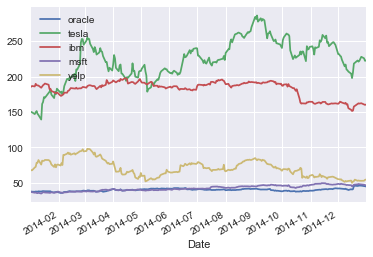

In [245]:
df.ORCL.plot(label = 'oracle')
df.TSLA.plot(label = 'tesla')
df.IBM.plot(label = 'ibm')
df.MSFT.plot(label = 'msft')
df.YELP.plot(label = 'yelp')
_ = plt.legend(loc='best')

Next, we will calculate returns over a period of length $T$, defined as:

$$r(t) = \frac{f(t)-f(t-T)}{f(t)} $$

The returns can be computed with a simple DataFrame method **`pct_change()`**.  Note that for the first $T$ timesteps, this value is not defined (of course):

In [246]:
rets = df.pct_change(30)
rets.iloc[25:35]

,IBM,MSFT,ORCL,TSLA,YELP
Date,,,,,
2014-11-24,NaN,NaN,NaN,NaN,NaN
2014-11-21,NaN,NaN,NaN,NaN,NaN
2014-11-20,NaN,NaN,NaN,NaN,NaN
2014-11-19,NaN,NaN,NaN,NaN,NaN
2014-11-18,NaN,NaN,NaN,NaN,NaN
2014-11-17,0.023186,0.064801,-0.084723,0.141945,0.059748
2014-11-14,0.025679,0.054445,-0.099250,0.164019,0.102876
2014-11-13,0.014205,0.045522,-0.107213,0.115148,0.096020
2014-11-12,-0.002587,0.018797,-0.129284,0.093407,0.144314


Now we'll plot the timeseries of the returns of the different stocks.

Notice that the `NaN` values are gracefully dropped by the plotting function.

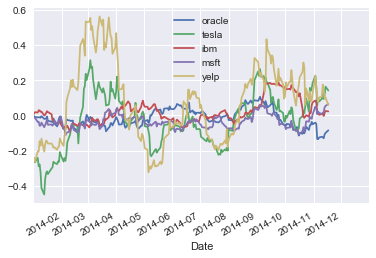

In [247]:
rets.ORCL.plot(label = 'oracle')
rets.TSLA.plot(label = 'tesla')
rets.IBM.plot(label = 'ibm')
rets.MSFT.plot(label = 'msft')
rets.YELP.plot(label = 'yelp')
_ = plt.legend(loc='best')

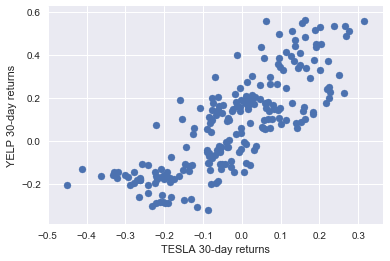

In [248]:
plt.scatter(rets.TSLA, rets.YELP)
plt.xlabel('TESLA 30-day returns')
_ = plt.ylabel('YELP 30-day returns')

There appears to be some (fairly strong) correlation between the movement of TSLA and YELP stocks.  Let's measure this.

The correlation coefficient between variables $X$ and $Y$ is defined as follows:

$$\text{Corr}(X,Y) = \frac{E\left[(X-\mu_X)(Y-\mu_Y)\right]}{\sigma_X\sigma_Y}$$

Pandas provides a DataFrame method to compute the correlation coefficient of all pairs of columns: **`corr()`**.

In [249]:
rets.corr()

,IBM,MSFT,ORCL,TSLA,YELP
IBM,1.000000,0.321583,0.042213,0.208735,0.103837
MSFT,0.321583,1.000000,0.130515,0.492674,0.282827
ORCL,0.042213,0.130515,1.000000,0.032724,-0.065211
TSLA,0.208735,0.492674,0.032724,1.000000,0.800936
YELP,0.103837,0.282827,-0.065211,0.800936,1.000000


It takes a bit of time to examine that table and draw conclusions.  

To speed that process up it helps to visualize the table.

We will learn more about visualization later, but for now this is a simple example.

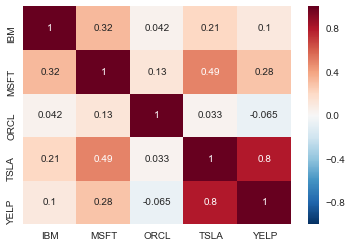

In [250]:
_ = sns.heatmap(rets.corr(), annot=True)

Finally, it is important to know that the plotting performed by Pandas is just a layer on top of `matplotlib` (i.e., the `plt` package).  

So Panda's plots can (and should) be replaced or improved by using additional functions from `matplotlib`.

For example, suppose we want to know both the returns as well as the standard deviation of the returns of a stock (i.e., its risk).  

Here is visualization of the result of such an analysis, and we construct the plot using only functions from `matplotlib`.

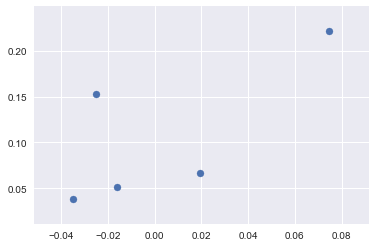

In [251]:
_ = plt.scatter(rets.mean(), rets.std())
# plt.xlabel('Expected returns')
# plt.ylabel('Standard Deviation (Risk)')
# for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
#    plt.annotate(
#        label, 
#        xy = (x, y), xytext = (20, -20),
#        textcoords = 'offset points', ha = 'right', va = 'bottom',
#        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
#        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

To understand what these functions are doing, (especially the `annotate` function), you will need to consult the online documentation for matplotlib.  Just use Google to find it.